<a href="https://colab.research.google.com/github/itberrios/CV_projects/blob/main/mars_challenge/mars_challenge_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Mars Challenge**

The [MARS Challenge](https://blog.marsauto.com/introducing-the-mars-challenge-fc84c5afafbe) involves estimated the velocity of an ego camera mounted on a vehicel using only video (with train and test splits)

We will attempt the MARS challenge with a simple approach that involves the following steps

1. Compute Camera Motion Compension transformation matrix
2. Use Transformation Matrix and true speed values to train a model that will regress the ego vehicle speed


Before we begin training the model, we will apply a Kalman Filter to smooth the training speed data.

<br>

## Let's get started!

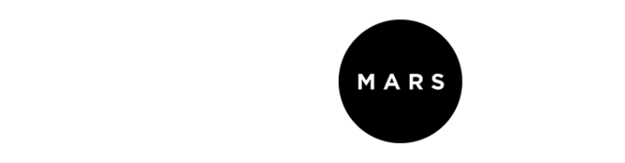

Download the data

In [ ]:
!wget https://marschallenge.s3.ap-northeast-2.amazonaws.com/train.mp4
!wget https://marschallenge.s3.ap-northeast-2.amazonaws.com/train.txt
!wget https://marschallenge.s3.ap-northeast-2.amazonaws.com/test.mp4

### **Import Libraries**

In [ ]:
!pip install filterpy

In [1]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

%matplotlib inline

## **Apply Kalman Filter to Training Data**

In [2]:
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise

# parameters
dt = 1 # time step
q_var = 0.25 # Process noise covariance
r_var = 5.0  # measurment noise covairance
x_var = 1000.0 # noise covariance


#  wrap in function to make parameter tuning easier
def get_kalman_filter(dt, q_var, r_var, x_var):
    """
    dt - time step
    q_var - Process noise covariance
    r_var - measurment noise covairance
    x_var - process noise covariance
    """

    # creat Kalman Filter Object
    kf = KalmanFilter(dim_x=3, dim_z=2)

    # state vector
    kf.x = np.array([[0.0],  # position
                     [0.0],  # speed
                     [0.0]]) # acceleration

    # state transition matrix
    kf.F = np.array([[1, dt, 0.5*dt**2],  # x position
                     [0,  1,        dt],  # x speed
                     [0,  0,         1]]) # x acceleration

    # measurement matrix (funtion) --> only measure speed and acceleration
    kf.H = np.array([[0.0, 1.0, 1.0],
                     [0.0, 0.0, 1.0]])

    # covariance matrix
    kf.P *= x_var

    # measurment noise (how much we trust our measurements)
    kf.R[0,0] *= r_var    # speed measurements
    kf.R[1,1] *= 5*r_var  # acceleration measurements

    # Process Noise (how much we trust our model)
    kf.Q = Q_discrete_white_noise(dim=3, dt=dt, var=q_var)

    return kf


def get_filtered_states(y_data, kf_obj, dt):
    x_states = []

    prev_xs = 0.0
    z = np.array([[0.0, 0.0]])
    for xs in y_data:

        # get measurements
        xa = (xs - prev_xs)/dt   # get acceleration
        z = np.array([[xs, xa]]) # get measurment

        # update with new measurement
        kf_obj.update(z)
        x_states.append(kf.x)

        # predict next state
        kf_obj.predict()

        # store prev speed
        prev_xs = xs

    return np.array(x_states)

In [3]:
# load training data
y_train = np.loadtxt('train.txt')

# create kalman Filter Object
kf = get_kalman_filter(dt, q_var, r_var, x_var)

# filter speed data
x_states = get_filtered_states(y_train, kf, dt)
y_train_smooth = x_states[:, 1]

## **Set up pipeline to collect transformation matrices for each frame pair**

In order to compute the transformation matrix from one frame to the next, we will first need to compute features (i.e. points of interest) on both frames and find a way to match them. This presents a challenging problem, but thankfully opencv has built in implementations that will allow us to do this. The general steps are:
1. Compute location of feature points on frame 1
2. Find those corresponding feature point locations on frame 2
3. Estimate 2D affine transformation matrix using meatching features from both frames


The fine details of these steps can actually change depending on which method we use to compute the features. For example, one method might be suited for sparse optical flow while another might be suited for Brute Force or K-Nearest Neighbors matching.

In [4]:
# first method that computes A with optical flow
def compute_motion_flow(frame1 : np.ndarray,
                        frame2 : np.ndarray,
                        method : int,
                        params : dict) -> np.ndarray:
    """
    Computes motion compensation transformation matrix (a rigid body transform)
    from frame 1 to frame 2
    Inputs:
      frame 1 - first grayscale frame
      frame 2 - second grayscale frame
      method - determines the method of feature detection
      params - parameters for feature detection
    Outputs:
      A - 2x3 Affine Transformation matrix that maps frame1 to frame2
      prev_points - key points in frame 1
      curr_points - matched key points in frame 2
    """

    # get corners of first image
    if method == 0:
        fast = cv2.FastFeatureDetector_create(**params)
        corners = cv2.KeyPoint_convert(fast.detect(frame1, None))
    elif method == 1:
        corners = cv2.goodFeaturesToTrack(frame1, **params)

    # get matching features on next image
    matched_corners, status, error = cv2.calcOpticalFlowPyrLK(frame1, frame2, corners, None)

    # get valid matched features
    status = status.reshape((-1))
    prev_points = corners.reshape((-1, 2))[status==1]
    curr_points = matched_corners.reshape((-1, 2))[status==1]

    # estimate transformation matrix from frame 1 to frame 2
    A, _ = cv2.estimateAffinePartial2D(prev_points, curr_points, method=cv2.RANSAC)

    return A, prev_points, curr_points


# second method with ORB and KNN matching
def compute_motion_matching(frame1 : np.ndarray,
                            frame2 : np.ndarray,
                            orb : cv2.ORB,
                            flann : cv2.FlannBasedMatcher) -> np.ndarray:
    """
        Computes motion compensation transformation matrix (a rigid body transform)
        from frame 1 to frame 2
        Inputs:
          frame 1 - first grayscale frame
          frame 2 - second grayscale frame
          orb - opencv orb object
          flann - opencv flann object
        Outputs:
          A - 2x3 Affine Transformation matrix that maps frame1 to frame2
          prev_points - key points in frame 1
          curr_points - matched key points in frame 2
        """

    # use ORB to get features and descriptors on both frames
    # find the keypoints with ORB
    kp1 = orb.detect(frame1, None)
    kp2 = orb.detect(frame2, None)
    # compute the descriptors with ORB
    kp1, des1 = orb.compute(frame1, kp1)
    kp2, des2 = orb.compute(frame2, kp2)

    # descriptors must be float32
    matches = flann.knnMatch(des1.astype(np.float32), des2.astype(np.float32), k=2)

    # get affine matrix
    good = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good.append(m)


    prev_points = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
    curr_points = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)
    A, _ = cv2.estimateAffinePartial2D(prev_points, curr_points, method=cv2.RANSAC)

    return A, prev_points, curr_points

### **Speed Test**

We will try 3 methods of feature detection to compute the transformation matrices between each frame:
- FAST
- Shi Thomasi
- ORB

In [5]:
cap = cv2.VideoCapture("train.mp4")

if (cap.isOpened() == False):
    print("Error opening video file")

frames = []
i = 0
while(cap.isOpened()):

    # read each video frame
    ret, frame = cap.read()

    if ret == True:
        frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY))

        # increment counter
        i += 1

        if (i > 1200):
            break

    # Break if nothing is returned
    else:
        break

# clean up
cap.release()
cv2.destroyAllWindows()
del cap

In [6]:
gray1 = frames[1000]
gray2 = frames[1001]

Set Parameters

In [7]:
# FAST (larger threshold --> fewer features )
params_0 = {'threshold' : 10} # try 10 or 30

# Shi-Thomasi
params_1 = {'maxCorners' : 2000,
            'qualityLevel' : 0.01,
            'minDistance' : 10}


In [8]:
# Initiate ORB detector
orb = cv2.ORB_create(nfeatures=5000)

# initiate FLANN matcher
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50) # or pass empty dictionary
flann = cv2.FlannBasedMatcher(index_params,search_params)

In [9]:
# FAST
%timeit A0, prev_points_0, curr_points_0 = compute_motion_flow(gray1, gray2, method=0, params=params_0)

104 ms ± 29.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [10]:
# Shi Thomasi
%timeit A1, prev_points_1, curr_points_1 = compute_motion_flow(gray1, gray2, method=1, params=params_1)

30.4 ms ± 8.75 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [11]:
# ORB
%timeit A2, prev_points_2, curr_points_2 = compute_motion_matching(gray1, gray2, orb, flann)

194 ms ± 9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
A0, prev_points_0, curr_points_0 = compute_motion_flow(gray1, gray2, method=0, params=params_0)
A1, prev_points_1, curr_points_1 = compute_motion_flow(gray1, gray2, method=1, params=params_1)
A2, prev_points_2, curr_points_2 = compute_motion_matching(gray1, gray2, orb, flann)

In [13]:
len(prev_points_0), len(prev_points_1), len(prev_points_2)

(5208, 812, 1511)

It looks like Shi-Thomasi has a signficiant speed advantage, but less points. While less feature points means more speed, having more points allows us to more accurately estimate the affine transformation matrix.

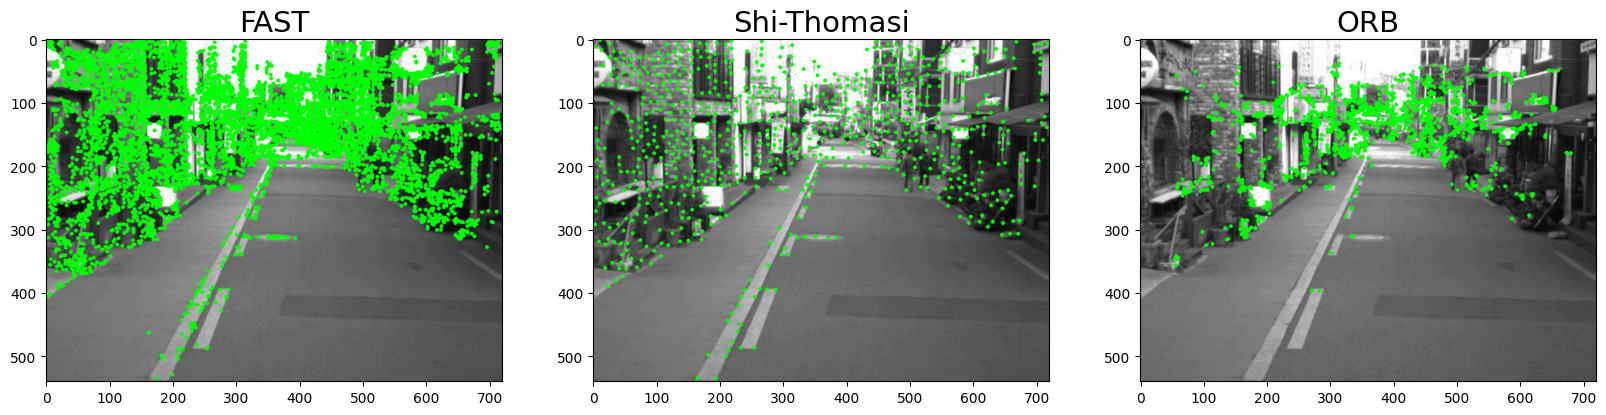

In [14]:
def plot_points(image, points):
    for x,y in points:
        cv2.circle(image, (int(x), int(y)), radius=3, color=(0,255,0), thickness=-1)

    return image

image_rgb_0 = plot_points(np.dstack((gray1, gray1, gray1)), prev_points_0)
image_rgb_1 = plot_points(np.dstack((gray1, gray1, gray1)), prev_points_1)
image_rgb_2 = plot_points(np.dstack((gray1, gray1, gray1)), prev_points_2.squeeze())

_, ax = plt.subplots(1, 3, figsize=(20, 8))
ax[0].imshow(image_rgb_0)
ax[0].set_title('FAST', size=21)
ax[1].imshow(image_rgb_1)
ax[1].set_title('Shi-Thomasi', size=21)
ax[2].imshow(image_rgb_2)
ax[2].set_title('ORB', size=21);

If we look closely at the computed features, we can see that FAST seemed to get everything, in fact more than enough. Shi-Thomasi is very spread out and seems to distill the important points in the entire frame. ORB on the other hand only seems to find a small subset in the center of the image.

Tuning FAST to reduce the total number of points is effective at increasing the speeed of computing the transformation matrix, but it missed major features (try a threshold of 10 VS 30). On the other hand Shi-Thomasi seems to get good features at a fast speed so we will go with that one.

#### **Stream video and get training features**

In [51]:
cap = cv2.VideoCapture("train.mp4")

if (cap.isOpened() == False):
    print("Error opening video file")

X = []
prev_frame = None
i = 0
while(cap.isOpened()):

    # read each video frame
    ret, frame = cap.read()

    if ret == True:
        if i > 0:
          gray1 = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
          gray2 = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
          A, _, _ = compute_motion_flow(gray1, gray2, method=1, params=params_1)

          # update features (transpose allows for separation of rot and trans)
          X.append(A.T.flatten())

        # update previous frame
        prev_frame = frame.copy()

        # increment counter
        i += 1

    # Break if nothing is returned
    else:
        break

# clean up
cap.release()
cv2.destroyAllWindows()
del cap

#### **Get Test Features**

In [52]:
cap = cv2.VideoCapture("test.mp4")

if (cap.isOpened() == False):
    print("Error opening video file")

X_test = []
prev_frame = None
i = 0
while(cap.isOpened()):

    # read each video frame
    ret, frame = cap.read()

    if ret == True:
        if i > 0:
          gray1 = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
          gray2 = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
          A_test, _, _ = compute_motion_flow(gray1, gray2, method=1, params=params_1)

          # update features (transpose allows for separation of rot and trans)
          X_test.append(A_test.T.flatten())

        # update previous frame
        prev_frame = frame.copy()

        # increment counter
        i += 1

    # Break if nothing is returned
    else:
        break

# clean up
cap.release()
cv2.destroyAllWindows()
del cap

Store feature array in .txt file

In [53]:
# place in array and account for first frame
X = np.vstack((np.zeros(6), np.array(X)))
X_test = np.vstack((np.zeros(6), np.array(X_test)))
print(X.shape, X_test.shape)

np.savetxt('train_X.txt', X)
np.savetxt('test_X.txt', X_test)
np.savetxt('train_y_smooth.txt', y_train_smooth)

# convert back to 2x3 Transformation Matrix
# X[-1, :].reshape((3,2)).T

(8100, 6) (6173, 6)


Load training data if necessary

In [15]:
# load training data
X = np.loadtxt('train_X.txt')

y = np.loadtxt('train_y_smooth.txt')
# y = y_train_smooth.copy() # use smoothed training data


# neglect first training sample
y = y[1:]
X = X[1:, :]

print(X.shape, y.shape)

(8099, 6) (8099,)


The training data that we have just aquired consists of the Camera Motion Compensation transformation for speed at each time stamp (except the first).

## **Break into train, valid, test splits**


In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=0)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.5, shuffle=True, random_state=0)

In [17]:
X_train.shape, X_valid.shape, X_test.shape

((6479, 6), (810, 6), (810, 6))

## **Study the Collected Features of the train split**

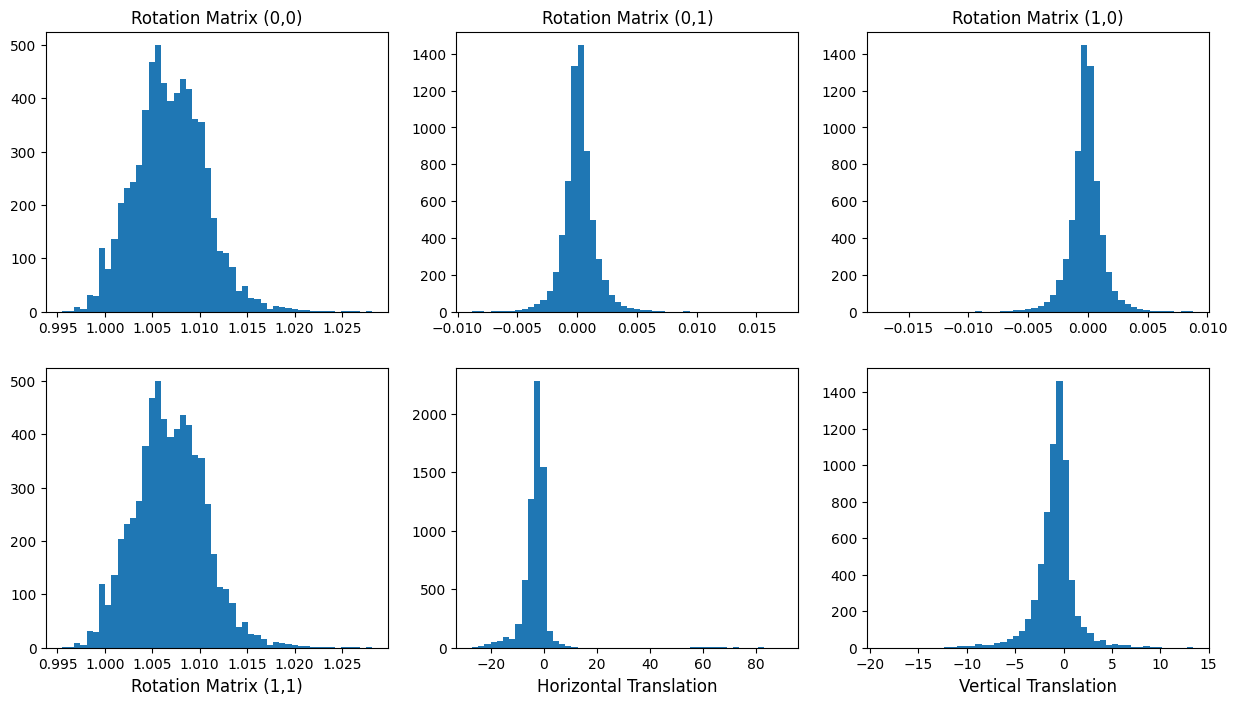

In [18]:
_, ax = plt.subplots(2, 3, figsize=(15, 8))
ax[0, 0].hist(X_train[:, 0], bins=50)
ax[0, 0].set_title("Rotation Matrix (0,0)", size=12)
ax[0, 1].hist(X_train[:, 1], bins=50)
ax[0, 1].set_title("Rotation Matrix (0,1)", size=12)
ax[0, 2].hist(X_train[:, 2], bins=50)
ax[0, 2].set_title("Rotation Matrix (1,0)", size=12)
ax[1, 0].hist(X_train[:, 3], bins=50)
ax[1, 0].set_xlabel("Rotation Matrix (1,1)", size=12)
ax[1, 1].hist(X_train[:, 4], bins=50)
ax[1, 1].set_xlabel("Horizontal Translation", size=12)
ax[1, 2].hist(X_train[:, 5], bins=50)
ax[1,2].set_xlabel("Vertical Translation", size=12);


We can see that the mean values of the rotation matrices are very close to the Identity matrix, while the (x,y) translation values are mostly non-zero. So the translation values are going to provide most of the information.

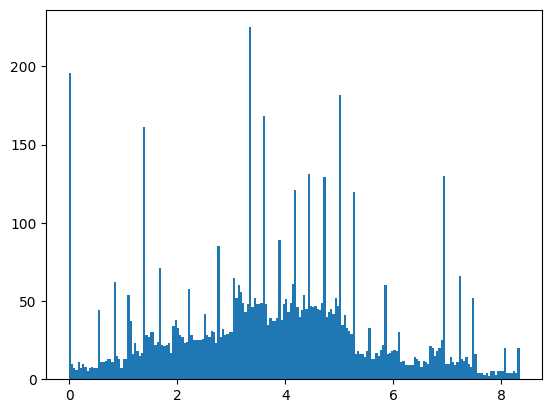

In [19]:
plt.hist(y_train, bins=200);

We will operate under the assumption that large outliers are due to large object motion and not camera motion. We further assume that true camera motion is very small and incremental.

There is an issue with the speed data and that can be identified by the large spikey modes in the histogram above. These spikey modes correspond to times where the speed measurement incorrectly freezes at the same value for a small period of time. We can identify these times and remove them from the training set, but we opt to keep them in because they are roughly close to the true speed and probably sufficient for model training.

## **Augment Train split**

We will make the assumption that when there is no translation or rotation, we will have a speed of 0. So we may want to consider adding some augmented samples that have an identity rotation matrix with a 0 translation vector that corresponds to a 0 speed. A case against adding the aufmentation is that there is some background movement that would make 0 speed cases have transformation matrices that correspond to very small amounts of motion.

<br>

**NOTE: It seems like the acquired motion compensations are not ideal even when the vehicle speed is zero. Adding this augmentation could really mess things up, since it could change the distribution of the acquired data! The code to generate the augmented data is inclued, but we will not add this augmnentation in this notebook**

In [20]:
n_aug = 500

x_aug = np.zeros((2, 3))
x_aug[0, 0] = 1.0
x_aug[1, 1] = 1.0

X_aug = np.repeat(np.c_[x_aug.T.flatten()], 100, axis=1).T
y_aug = np.zeros((n_aug,))

In [21]:
X_aug.shape, y_aug.shape

((100, 6), (500,))

In [22]:
from sklearn.preprocessing import StandardScaler

x_scaler = StandardScaler().fit(X_train)
y_scaler = StandardScaler().fit(y_train.reshape((-1, 1)))

In [23]:
# test scaler
x_scaler.transform(X_train).mean(axis=0), x_scaler.transform(X_train).std(axis=0)

(array([-7.90521633e-14, -3.97347261e-16,  3.97347261e-16, -7.90521633e-14,
        -1.66594285e-15,  3.46422056e-16]),
 array([1., 1., 1., 1., 1., 1.]))

In [24]:
# test inverse scaler
X_train.mean(axis=0), X_train.std(axis=0)

(array([ 1.00685856e+00,  1.67779185e-04, -1.67779185e-04,  1.00685856e+00,
        -3.23530577e+00, -8.36619497e-01]),
 array([3.70724763e-03, 1.40981812e-03, 1.40981812e-03, 3.70724763e-03,
        6.12261239e+00, 2.07808680e+00]))

In [25]:
x_scaler.inverse_transform(x_scaler.transform(X_train)).mean(axis=0), x_scaler.inverse_transform(x_scaler.transform(X_train)).std(axis=0)

(array([ 1.00685856e+00,  1.67779185e-04, -1.67779185e-04,  1.00685856e+00,
        -3.23530577e+00, -8.36619497e-01]),
 array([3.70724763e-03, 1.40981812e-03, 1.40981812e-03, 3.70724763e-03,
        6.12261239e+00, 2.07808680e+00]))

# **Build Baseline Models**

For this tutorial we will build a few baseline models
- Linear Model
- Neural Network
- Support Vector Machine
- Random Forest
- XGBoost

In [26]:
import xgboost as xgb
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn import svm


# enet = ElasticNet(alpha=0.1, l1_ratio=0.05, random_state=0)
lreg = LinearRegression()
svr = svm.SVR()
xgb_rf = xgb.XGBRFRegressor(random_state=0)
xgbr = xgb.XGBRegressor(random_state=0)

Build neural network

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(6, 10)
        self.fc2 = nn.Linear(10, 4)
        self.fc3 = nn.Linear(4, 1)

    def forward(self, x):
        # x1 = F.relu(self.fc1(x))
        # x2 = F.relu(self.fc2(x1))
        # x3 = F.relu(self.fc3(x2 + x1))

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))

        return x


net = Net()
print(net)

# test pass
# net(torch.rand(32, 6))

Net(
  (fc1): Linear(in_features=6, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=4, bias=True)
  (fc3): Linear(in_features=4, out_features=1, bias=True)
)


### **Train models**

In [28]:
# scale data
X_train_s = x_scaler.transform(X_train)
y_train_s = y_scaler.transform(y_train.reshape((-1, 1)))
X_valid_s = x_scaler.transform(X_valid)
y_valid_s = y_scaler.transform(y_valid.reshape((-1, 1)))


lreg.fit(X_train_s, y_train_s)
print("Linear Regression fit complete")

svr.fit(X_train_s, y_train_s.ravel())
print("Support Vector Machine Regressor fit complete")

xgb_rf.fit(X_train_s, y_train_s)
print("Random Forest fit complete")

xgbr.fit(X_train_s, y_train_s)
print("XGBoost fit complete")

Linear Regression fit complete
Support Vector Machine Regressor fit complete
Random Forest fit complete
XGBoost fit complete


Get train RMSE

In [29]:
from sklearn.metrics import mean_squared_error

# Linear Regression
y_train_lreg_preds = lreg.predict(X_train_s)

lreg_train_rmse = mean_squared_error(y_train_s, y_train_lreg_preds)
print(f"Linear Regression train RMSE: {lreg_train_rmse}")

# Support Vector Regressor
y_train_svr_preds = svr.predict(X_train_s)

svr_train_rmse = mean_squared_error(y_train_s, y_train_svr_preds)
print(f"SVR train RMSE: {svr_train_rmse}")

# Random Forest
y_train_rf_preds = xgb_rf.predict(X_train_s)

rf_train_rmse = mean_squared_error(y_train_s, y_train_rf_preds)
print(f"Random Forest train RMSE: {rf_train_rmse}")

# XG Boost
y_train_xgb_preds = xgbr.predict(X_train_s)

xgb_train_rmse = mean_squared_error(y_train_s, y_train_xgb_preds)
print(f"XG Boost train RMSE: {xgb_train_rmse}")

Linear Regression train RMSE: 0.7703593832044219
SVR train RMSE: 0.5232557266646306
Random Forest train RMSE: 0.42542468353992957
XG Boost train RMSE: 0.1496112910638082


Train Neural Network

In [68]:
from torch.utils.data import Dataset, DataLoader


class CustomDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        return x,y

    def __len__(self):
        return len(self.data)


train_dataset = CustomDataset(x_scaler.transform(X_train),
                              y_scaler.transform(y_train.reshape((-1, 1))))
valid_dataset = CustomDataset(x_scaler.transform(X_valid),
                              y_scaler.transform(y_valid.reshape((-1, 1))))

trainloader = DataLoader(train_dataset, batch_size=32)
validloader = DataLoader(valid_dataset, batch_size=32)

In [69]:
import torch.optim as optim

criterion = nn.MSELoss()
# optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.005)
optimizer = optim.Adam(net.parameters(), lr=0.03)

In [70]:
train_loss = []
valid_loss = []
for e in range(100):

    # train loop
    train_losses = []
    for x,y in trainloader:
        # cast to float32
        x, y = x.to(torch.float), y.to(torch.float)

        y_pred = net(x)
        loss = torch.sqrt(criterion(y, y_pred))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_losses.append(loss.detach().numpy())

    # update loss
    train_loss.append(np.sum(train_losses)/len(trainloader))


    # validation loop
    valid_losses = []
    with torch.no_grad():
        for x,y in validloader:
            # cast to float32
            x, y = x.to(torch.float), y.to(torch.float)

            y_pred = net(x)
            loss = torch.sqrt(criterion(y, y_pred))

            valid_losses.append(loss.detach().numpy())

        valid_loss.append(np.sum(valid_losses)/len(validloader))

    # print progress
    print(f"Epoch: {e+1} - train loss: {train_loss[-1]} - valid loss: {valid_loss[-1]}")

Epoch: 1 - train loss: 0.9330366162830973 - valid loss: 0.9291976781991812
Epoch: 2 - train loss: 0.9015244357104372 - valid loss: 0.9217397249661959
Epoch: 3 - train loss: 0.8967475327364917 - valid loss: 0.9212476290189303
Epoch: 4 - train loss: 0.8965960723425954 - valid loss: 0.9176035660963792
Epoch: 5 - train loss: 0.8952955424491995 - valid loss: 0.9142875671386719
Epoch: 6 - train loss: 0.8936355665986762 - valid loss: 0.9131521811852088
Epoch: 7 - train loss: 0.8956454422673569 - valid loss: 0.9154130495511569
Epoch: 8 - train loss: 0.8932675516664101 - valid loss: 0.9134403375478891
Epoch: 9 - train loss: 0.8932510150477216 - valid loss: 0.9140516427847055
Epoch: 10 - train loss: 0.8933191910165871 - valid loss: 0.9115835336538461
Epoch: 11 - train loss: 0.8939544978400169 - valid loss: 0.9110776461087741
Epoch: 12 - train loss: 0.8917906812846367 - valid loss: 0.912090961749737
Epoch: 13 - train loss: 0.8923219577432266 - valid loss: 0.9060573577880859
Epoch: 14 - train loss

## **Validate Models**

In [30]:
# Linear Regression
y_valid_lreg_preds = lreg.predict(X_valid_s)

lreg_valid_rmse = mean_squared_error(y_valid_s, y_valid_lreg_preds)
print(f"Linear Regression validation RMSE: {lreg_valid_rmse}")

# Support Vector Regressor
y_valid_svr_preds = svr.predict(X_valid_s)

svr_valid_rmse = mean_squared_error(y_valid_s, y_valid_svr_preds)
print(f"SVR validation RMSE: {svr_valid_rmse}")

# Random Forest
y_valid_rf_preds = xgb_rf.predict(X_valid_s)

rf_valid_rmse = mean_squared_error(y_valid_s, y_valid_rf_preds)
print(f"Random Forest validation RMSE: {rf_valid_rmse}")

# XG Boost
y_valid_xgb_preds = xgbr.predict(X_valid_s)

xgb_valid_rmse = mean_squared_error(y_valid_s, y_valid_xgb_preds)
print(f"XG Boost validation RMSE: {xgb_valid_rmse}")

Linear Regression validation RMSE: 0.815293201730072
SVR validation RMSE: 0.5784727448172444
Random Forest validation RMSE: 0.47384005436144694
XG Boost validation RMSE: 0.4234596793362096


## **Focus on Random Forest and XG Boost**

Tune these parameters

In [31]:
xgb_rf = xgb.XGBRFRegressor(
    n_estimators=100,
    max_depth=5,
    # max_leaves=0,
    # learning_rate=0.8,
    reg_alpha=0.01,
    # reg_lambda=0.1,
    # gamma=0,
    random_state=0
    )
xgbr = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=5,
    # random_state=0,
    # max_leaves=0,
    # learning_rate=0.8,
    # reg_alpha=0.01,
    # reg_lambda=0.1,
    # gamma=0,
    random_state=0
    )

In [32]:
xgb_rf.fit(X_train_s, y_train_s)
print("Random Forest fit complete")

xgbr.fit(X_train_s, y_train_s)
print("XGBoost fit complete")

Random Forest fit complete
XGBoost fit complete


In [33]:
# Random Forest
y_train_rf_preds = xgb_rf.predict(X_train_s)
y_valid_rf_preds = xgb_rf.predict(X_valid_s)

rf_train_rmse = mean_squared_error(y_train_s, y_train_rf_preds)
rf_valid_rmse = mean_squared_error(y_valid_s, y_valid_rf_preds)
print(f"Random Forest - train RMSE: {rf_train_rmse:.4f} - validation RMSE: {rf_valid_rmse:.4f}")

# XG Boost
y_train_xgb_preds = xgbr.predict(X_train_s)
y_valid_xgb_preds = xgbr.predict(X_valid_s)

xgb_train_rmse = mean_squared_error(y_train_s, y_train_xgb_preds)
xgb_valid_rmse = mean_squared_error(y_valid_s, y_valid_xgb_preds)
print(f"XG Boost - train RMSE: {xgb_train_rmse:.4f}  - validation RMSE: {xgb_valid_rmse:.4f}")

Random Forest - train RMSE: 0.4597 - validation RMSE: 0.5059
XG Boost - train RMSE: 0.2138  - validation RMSE: 0.4429


# **Retrain with all the data**

In [34]:
# # get y since we overwrote it in the NN training
# y = y_train_smooth.copy()
# y = y[1:]

In [35]:
X.shape, y.shape

((8099, 6), (8099,))

In [36]:
xgbr = xgb.XGBRegressor(random_state=0)

# scale data
scaler_x = StandardScaler().fit(X)
scaler_y = StandardScaler().fit(y.reshape((-1, 1)))

Xs = scaler_x.transform(X)
ys = scaler_y.transform(y.reshape((-1, 1)))

xgbr.fit(Xs, ys)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=0, ...)


# **Get training metrics**

We will filter training metrics and see which result is better compared to the filtered training data. Note: it will take a few iterations for the kalman filter to get up to speed (pun intended) with the speed data that it is filtering.

In [37]:
# XG Boost
y_train_preds = xgbr.predict(Xs)

# filter speed data
kf = get_kalman_filter(dt, q_var, r_var, x_var)
y_train_preds_filtered = get_filtered_states(y_train_preds, kf, dt)[:, 1]

train_rmse = mean_squared_error(ys, y_train_preds)
train_rmse_filtered = mean_squared_error(ys, y_train_preds_filtered)

print(f"XG Boost - train RMSE: {train_rmse:.4f}")
print(f"XG Boost - train RMSE filtered: {train_rmse_filtered:.4f}")

XG Boost - train RMSE: 0.1710
XG Boost - train RMSE filtered: 0.1417


Explore train RMSE with and without filtering

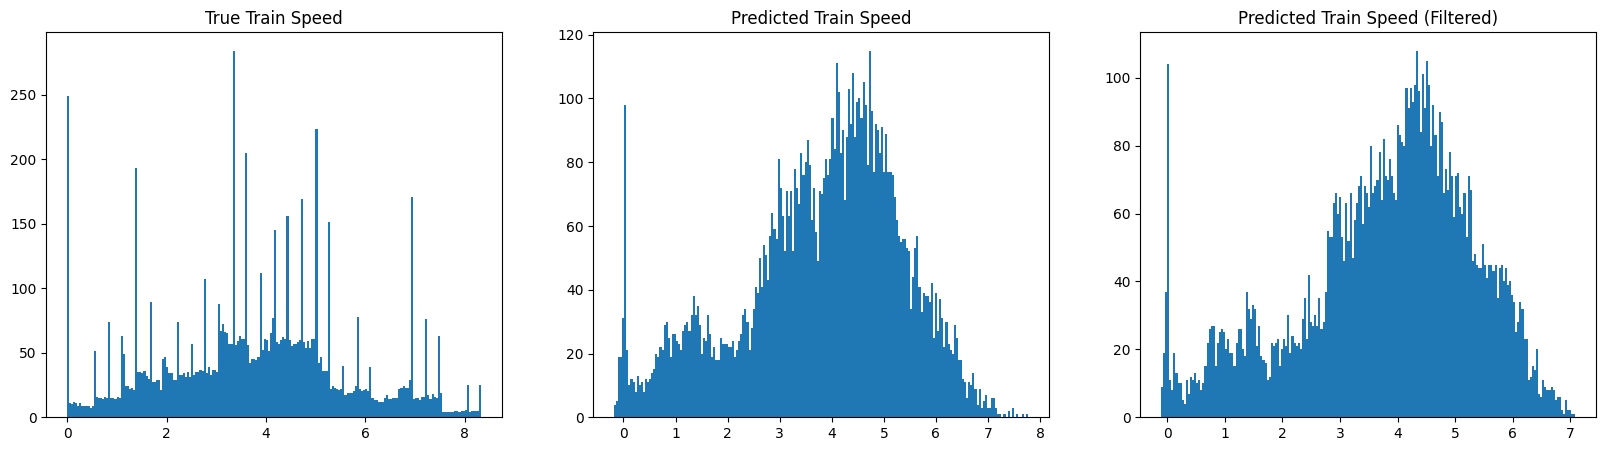

In [38]:
_, ax = plt.subplots(1, 3, figsize=(20, 5))
ax[0].hist(y, bins=200);
ax[0].set_title("True Train Speed")
ax[1].hist(scaler_y.inverse_transform(y_train_preds.reshape((-1,1))), bins=200)
ax[1].set_title("Predicted Train Speed");
ax[2].hist(scaler_y.inverse_transform(y_train_preds_filtered.reshape((-1,1))), bins=200)
ax[2].set_title("Predicted Train Speed (Filtered)");

#### **Inference on Test Data**

In [39]:
X_test = np.loadtxt('test_X.txt')
print(X_test.shape)

X_test_s = scaler_x.transform(X_test)

(6173, 6)


In [40]:
y_preds = xgbr.predict(X_test_s)

# filter speed data
kf = get_kalman_filter(dt, q_var, r_var, x_var)
y_preds_filtered = get_filtered_states(y_preds, kf, dt)[:, 1]

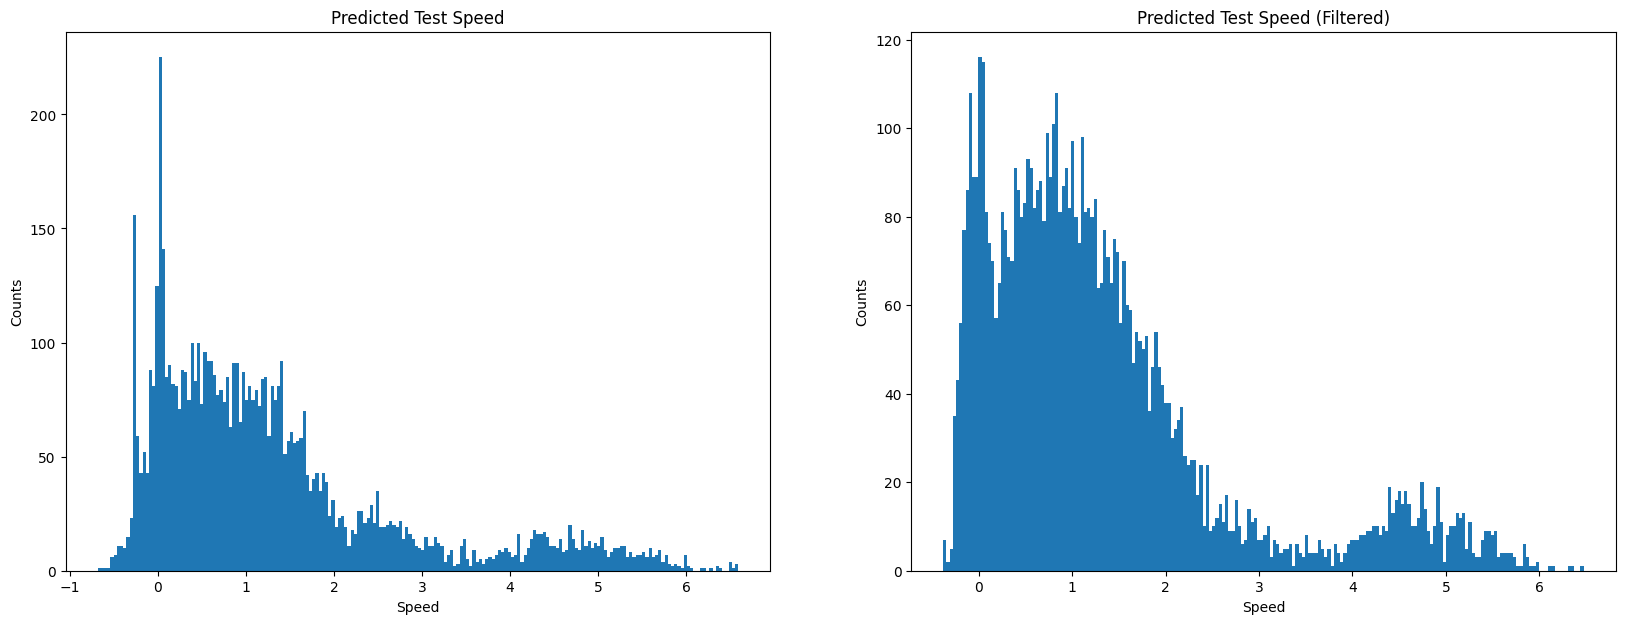

In [41]:
_, ax = plt.subplots(1, 2, figsize=(20, 7))
ax[0].hist(scaler_y.inverse_transform(y_preds.reshape((-1,1))), bins=200)
ax[0].set_title("Predicted Test Speed")
ax[0].set_xlabel('Speed')
ax[0].set_ylabel("Counts");
ax[1].hist(scaler_y.inverse_transform(y_preds_filtered.reshape((-1,1))), bins=200)
ax[1].set_title("Predicted Test Speed (Filtered)")
ax[1].set_xlabel('Speed')
ax[1].set_ylabel("Counts");

# **Make a Video**

Make one for the training data and another for the test data

In [42]:
rescaled_y_train_preds = scaler_y.inverse_transform(y_train_preds.reshape((-1,1)))
rescaled_y_train_preds_filtered = scaler_y.inverse_transform(y_train_preds_filtered.reshape((-1,1)))
rescaled_y_test_preds = scaler_y.inverse_transform(y_preds.reshape((-1,1)))
rescaled_y_test_preds_filtered = scaler_y.inverse_transform(y_preds_filtered.reshape((-1,1)))

In [43]:
np.savetxt("train_y_preds.txt", rescaled_y_train_preds)
np.savetxt("train_y_preds_filtered.txt", rescaled_y_train_preds_filtered)
np.savetxt("test_y_preds.txt", rescaled_y_test_preds)
np.savetxt("test_y_preds_filtered.txt", rescaled_y_test_preds_filtered)

In [45]:
# font
font = cv2.FONT_HERSHEY_SIMPLEX

# org
org_true = (15, 30)
org_pred = (15, 65)
org_filt = (15, 100)


# fontScale
fontScale = 1

# Blue color in BGR
color_true = (5, 255, 5)
color_pred = (255, 255, 255)

# Line thickness of 2 px
thickness = 3

In [29]:
cap = cv2.VideoCapture("train.mp4")

if (cap.isOpened() == False):
    print("Error opening video file")

train_fps = cap.get(cv2.CAP_PROP_FPS)
frames = []
i = 0
while(cap.isOpened()):

    # read each video frame
    ret, frame = cap.read()

    if ret == True:
        # get train truth and prediction
        if i == 0:
          y_true = y[i] # [0]
          y_pred = rescaled_y_train_preds[i][0]
          y_filt = rescaled_y_train_preds_filtered[i][0]
        else:
          y_true = y[i-1] # [0]
          y_pred = rescaled_y_train_preds[i-1][0]
          y_filt = rescaled_y_train_preds_filtered[i-1][0]

        # draw speeds on frame
        frame = cv2.putText(frame, f"True Speed: {y_true:.3f}", org_true, font,
                    fontScale, (0,0,0), 15, cv2.LINE_AA)
        frame = cv2.putText(frame, f"True Speed: {y_true:.3f}", org_true, font,
                            fontScale, color_true, thickness, cv2.LINE_AA)

        frame = cv2.putText(frame, f"Pred Speed: {y_pred:.3f}", org_pred, font,
                            fontScale, (0,0,0), 15, cv2.LINE_AA)
        frame = cv2.putText(frame, f"Pred Speed: {y_pred:.3f}", org_pred, font,
                            fontScale, color_pred, thickness, cv2.LINE_AA)

        frame = cv2.putText(frame, f"Filt Speed:  {y_filt:.3f}", org_filt, font,
                            fontScale, (0,0,0), 15, cv2.LINE_AA)
        frame = cv2.putText(frame, f"Filt Speed:  {y_filt:.3f}", org_filt, font,
                            fontScale, color_pred, thickness, cv2.LINE_AA)

        # save to list
        frames.append(frame)

        # increment counter
        i += 1

    # Break if nothing is returned
    else:
        break

# clean up
cap.release()
cv2.destroyAllWindows()
del cap

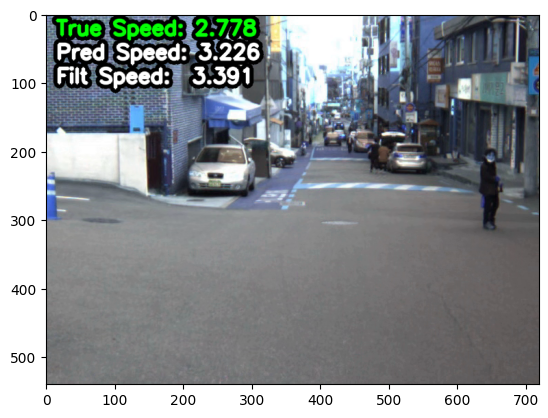

In [30]:
plt.imshow(frames[-1])

In [31]:
# save to mp4
w, h = frames[-1].shape[:2][::-1]
out = cv2.VideoWriter('train_output.mp4',
                      cv2.VideoWriter_fourcc(*'MP4V'),
                      train_fps,
                      (w, h))

for frame in frames:
    out.write(frame)
out.release()
del out

In [46]:
cap = cv2.VideoCapture("test.mp4")

if (cap.isOpened() == False):
    print("Error opening video file")

test_fps = cap.get(cv2.CAP_PROP_FPS)
test_frames = []
i = 0
while(cap.isOpened()):

    # read each video frame
    ret, frame = cap.read()

    if ret == True:
        # get test prediction
        if i == 0:
          y_pred = rescaled_y_test_preds[i][0]
          y_filt = rescaled_y_test_preds_filtered[i][0]
        else:
          y_pred = rescaled_y_test_preds[i-1][0]
          y_filt = rescaled_y_test_preds_filtered[i-1][0]

        # draw speed on frame
        frame = cv2.putText(frame, f"Pred Speed: {y_pred:.3f}", org_pred, font,
                            fontScale, (0,0,0), 15, cv2.LINE_AA)
        frame = cv2.putText(frame, f"Pred Speed: {y_pred:.3f}", org_pred, font,
                            fontScale, color_pred, thickness, cv2.LINE_AA)

        frame = cv2.putText(frame, f"Filt Speed:  {y_filt:.3f}", org_filt, font,
                            fontScale, (0,0,0), 15, cv2.LINE_AA)
        frame = cv2.putText(frame, f"Filt Speed:  {y_filt:.3f}", org_filt, font,
                            fontScale, color_pred, thickness, cv2.LINE_AA)

        # save to list
        test_frames.append(frame)

        # increment counter
        i += 1

    # Break if nothing is returned
    else:
        break

# clean up
cap.release()
cv2.destroyAllWindows()
del cap

#### **Save Videos**

In [47]:
# save to mp4
w, h = test_frames[-1].shape[:2][::-1]
out = cv2.VideoWriter('test_output.mp4',
                      cv2.VideoWriter_fourcc(*'MP4V'),
                      test_fps,
                      (w, h))

for frame in test_frames:
    out.write(frame)
out.release()
del out